In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mayo-clinic-strip-ai/sample_submission.csv
/kaggle/input/mayo-clinic-strip-ai/train.csv
/kaggle/input/mayo-clinic-strip-ai/test.csv
/kaggle/input/mayo-clinic-strip-ai/other.csv
/kaggle/input/mayo-clinic-strip-ai/other/314263_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/0b33d7_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/54334d_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/84c279_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/cca9eb_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/880188_1.tif
/kaggle/input/mayo-clinic-strip-ai/other/2e3078_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/9daa03_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/065053_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/8acdfa_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/91530f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/a2253f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/f5eb8f_1.tif
/kaggle/input/mayo-clinic-strip-ai/other/ab830f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/d17ad3_2.tif

(a) Large artery atherosclerosis (LAA); 열공성증후군이 아
니면서 DWI상 큰 병변이고 증상있는 혈관의 협착이 있을 때,

(b) Cardioembolism (CE); 임상적으로나 방사선학적으로 LAA
군과 비슷한 양상이지만 강력한 심인성 색전증을 일으킬 수 있
는 심질환이 있는 경우

# module

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io 
import PIL
import cv2
import os
import shutil
import glob
import tqdm
from openslide import OpenSlide 

# data load

In [3]:
train_csv = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test_csv = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')

image move(folder)

In [4]:
# train_list = os.listdir('../input/mayo-clinic-strip-ai/train')
# os.makedirs('./train/CE')
# os.makedirs('./train/LAA')
# for i in tqdm.tqdm(train_list): # 폴더로 파일 옮기기 (폴더수 빼주기(필요 없을지도))
#     file_name = i.split('.')[0]
#     wh = train_csv[train_csv['image_id'] == file_name]['label']
#     file_name
#     file_source = f'../input/mayo-clinic-strip-ai/train/{i}'
#     file_destination = f'./train/{wh}'
#     shutil.copy(file_source, file_destination)

# EDA

In [5]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int64 
 2   patient_id  754 non-null    object
 3   image_num   754 non-null    int64 
 4   label       754 non-null    object
dtypes: int64(2), object(3)
memory usage: 29.6+ KB


In [6]:
train_csv.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [7]:
train_csv.image_id.nunique()

754

In [8]:
train_csv.patient_id.nunique()

632

In [9]:
train_csv.label.value_counts()

CE     547
LAA    207
Name: label, dtype: int64

In [10]:
PIL.Image.MAX_IMAGE_PIXELS = None

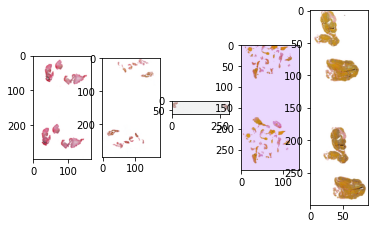

In [11]:
path = '../input/mayo-clinic-strip-ai/train'
for i in range(5):
    impath = os.path.join(path, os.listdir(path)[i])
    img = PIL.Image.open(impath)
    img.thumbnail((300,300), PIL.Image.Resampling.LANCZOS)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
plt.show()

In [12]:
for i in tqdm.tqdm(os.listdir(path)):
    a = OpenSlide(os.path.join(path, i))
    a.dimensions[0], a.dimensions[1]
    train_csv.loc[train_csv['image_id'] == i.split('.')[0], 'width'] = a.dimensions[0]
    train_csv.loc[train_csv['image_id'] == i.split('.')[0], 'height'] = a.dimensions[1]
    train_csv.loc[train_csv['image_id'] == i.split('.')[0], 'size'] = round(os.path.getsize(os.path.join(path, i)) / 1e6, 2)


100%|██████████| 754/754 [00:23<00:00, 31.91it/s]


In [13]:
train_csv

,image_id,center_id,patient_id,image_num,label,width,height,size
0,006388_0,11,006388,0,CE,34007.0,60797.0,1312.94
1,008e5c_0,11,008e5c,0,CE,5946.0,29694.0,109.57
2,00c058_0,11,00c058,0,LAA,15255.0,61801.0,351.76
3,01adc5_0,11,01adc5,0,LAA,55831.0,26553.0,679.17
4,026c97_0,4,026c97,0,CE,10533.0,8267.0,61.21
...,...,...,...,...,...,...,...,...
749,fe9645_0,3,fe9645,0,CE,19791.0,34118.0,127.16
750,fe9bec_0,4,fe9bec,0,LAA,36139.0,72763.0,405.41
751,ff14e0_0,6,ff14e0,0,CE,16452.0,43358.0,190.92
752,ffec5c_0,7,ffec5c,0,LAA,27394.0,60827.0,645.90


In [14]:
print(train_csv['width'].max())
print(train_csv['width'].min())
print(train_csv['height'].max())
print(train_csv['height'].min())

99699.0
4417.0
118076.0
4470.0


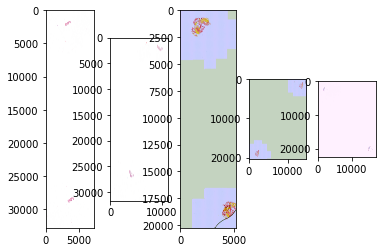

In [15]:
import matplotlib.image as mpimg
a = train_csv.sort_values('size')['image_id'][:5]
for i in range(5):
    impath = os.path.join(path, f'{a.values[i]}.tif')
    img = mpimg.imread(impath)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
plt.show()

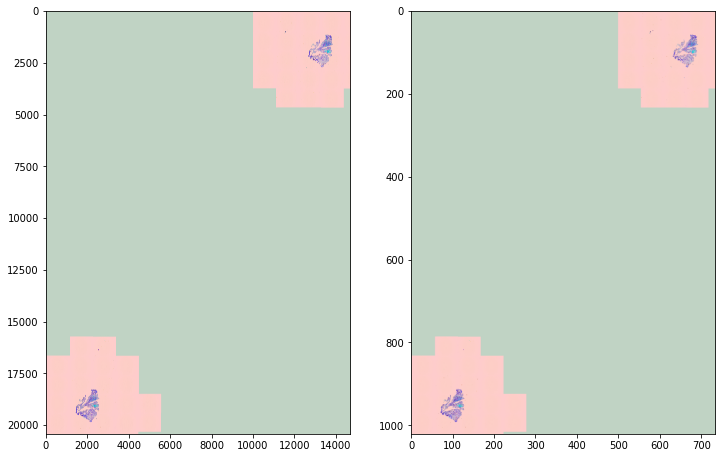

In [16]:
img_path = os.path.join(path, f'{a.values[3]}.tif')
img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(img, (0,0), fx=0.05, fy=0.05)
fig, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(img)
ax[1].imshow(image_resized)
plt.show()

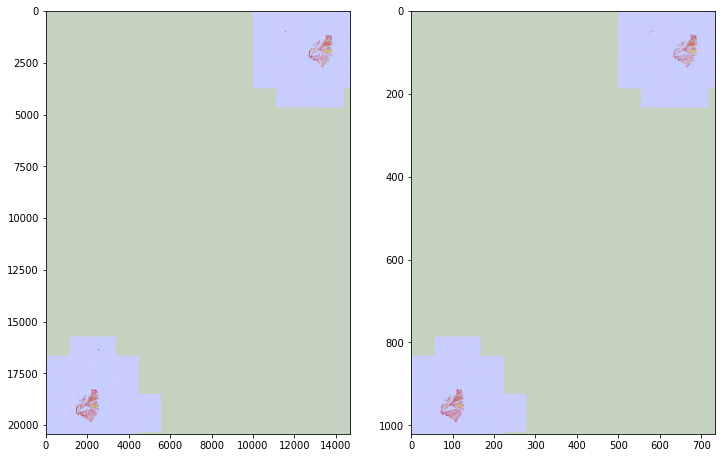

In [17]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(img, (0,0), fx=0.05, fy=0.05)
fig, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(img)
ax[1].imshow(image_resized)
plt.show()

In [18]:
print(f"Type of CV2 image: {type(img)}")
print(f"Memory occupied by CV2 image: {sys.getsizeof(img)/1e6:.2f}MB")
print(f"Memory occupied by reduced CV2 image: {sys.getsizeof(image_resized)/1e6:.2f}MB")
print(f'A shape of a resized image: ({image_resized.shape[0]}, {image_resized.shape[1]}). Number of color channels: {image_resized.shape[2]}')

Type of CV2 image: <class 'numpy.ndarray'>
Memory occupied by CV2 image: 899.95MB
Memory occupied by reduced CV2 image: 2.25MB
A shape of a resized image: (1021, 735). Number of color channels: 3


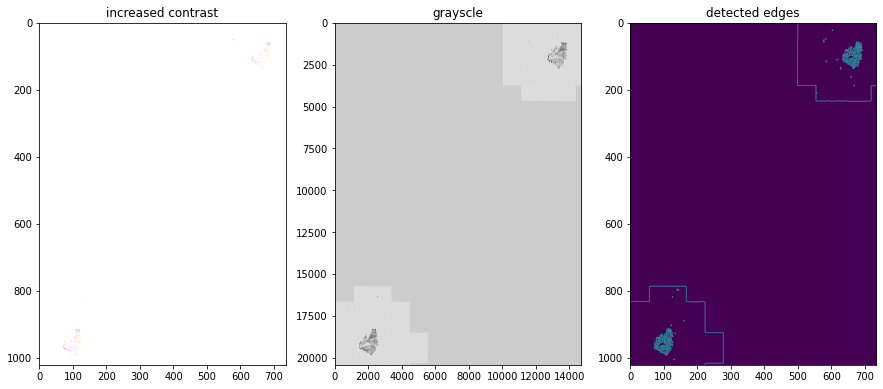

In [19]:
contrast_img = cv2.addWeighted(image_resized, 2.5, np.zeros(image_resized.shape, image_resized.dtype), 0, 0)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

min_intensity_grad, max_intensity_grad = 100, 200
edge_img = cv2.Canny(image_resized, min_intensity_grad, max_intensity_grad)

fig, ax = plt.subplots(1,3, figsize=(15,20))
ax[0].imshow(contrast_img); ax[0].set_title('increased contrast')
ax[1].imshow(img_gray, cmap='gray', vmin = 0, vmax = 255); ax[1].set_title('grayscle')
ax[2].imshow(edge_img); ax[2].set_title('detected edges')
plt.show()

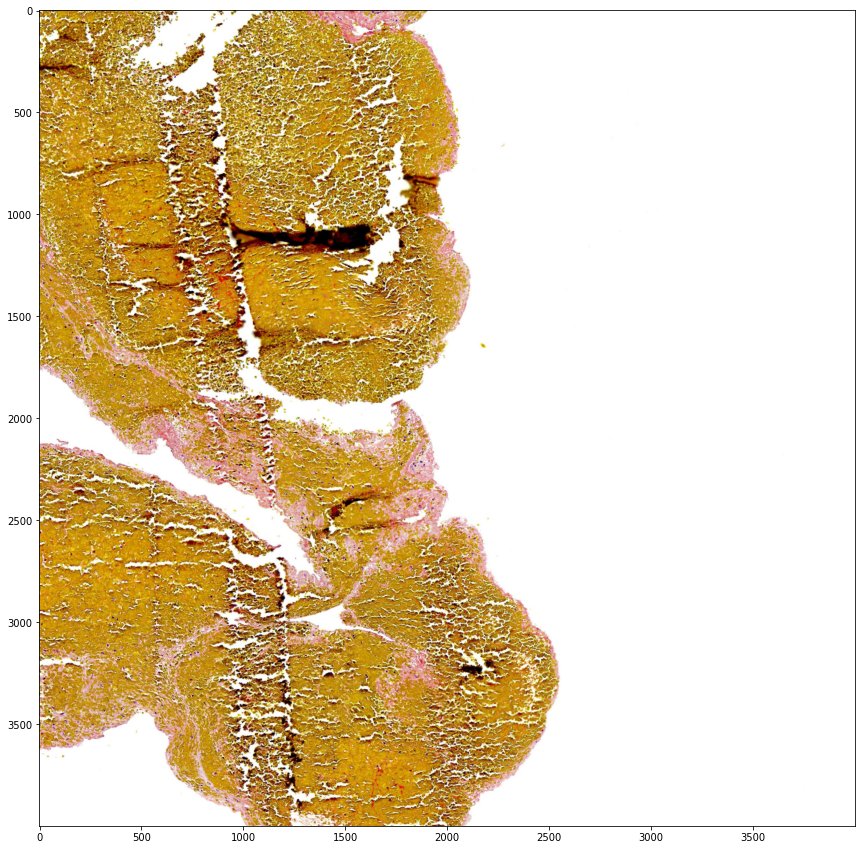

In [20]:
impath = impath = os.path.join(path, os.listdir(path)[4])
slide = OpenSlide(impath) # opening a full slide

region = (2500, 2000) # location of the top left pixel
level = 0 # level of the picture (we have only 0)
size = (4000, 4000) # region size in pixels

region = slide.read_region(region, level, size)

plt.figure(figsize=(15, 15))
plt.imshow(region)
plt.show()

In [21]:
# sliced_train_images = glob.glob("../input/mayo-clinic-strip-ai/train/*")
# fig, axes = plt.subplots(2,2, figsize=(20,20))
# for i, ax in enumerate(axes.flat):
#     img = io.imread(sliced_train_images[i])
#     ax.imshow(img); ax.set_title(i)
# plt.tight_layout()
# plt.show()